# LSTM
- [Pytorch] LSTM을 이용한 삼성전자 주가 예측하기 :  https://coding-yoon.tistory.com/131 



In [19]:
!pip uninstall charset-normalizer




^C


In [21]:
import numpy as np
import pandas as pd
# import pandas_datareader.data as pdr
import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



## 1. dataset
### 1) load

In [37]:
import yahoo_fin.stock_info as si
# from charset_normalizer import md__mypyc
import yfinance as yf

In [56]:
start = '01/01/2000'
# start = datetime.datetime(*start)

# 현재
end = datetime.date.today().strftime("%m/%d/%Y, %H:%M:%S")[:8]
print(end)

04/01/20


In [60]:
df = si.get_data('005930.KS',
                start_date= start,
                end_date= end)

print(len(df))
df.head()

5095


,open,high,low,close,adjclose,volume,ticker
2000-01-04,6000.0,6110.0,5660.0,6110.0,4469.932129,74195000,005930.KS
2000-01-05,5800.0,6060.0,5520.0,5580.0,4082.195801,74680000,005930.KS
2000-01-06,5750.0,5780.0,5580.0,5620.0,4111.459961,54390000,005930.KS
2000-01-07,5560.0,5670.0,5360.0,5540.0,4052.933594,40305000,005930.KS
2000-01-10,5600.0,5770.0,5580.0,5770.0,4221.195801,46880000,005930.KS


<Axes: >

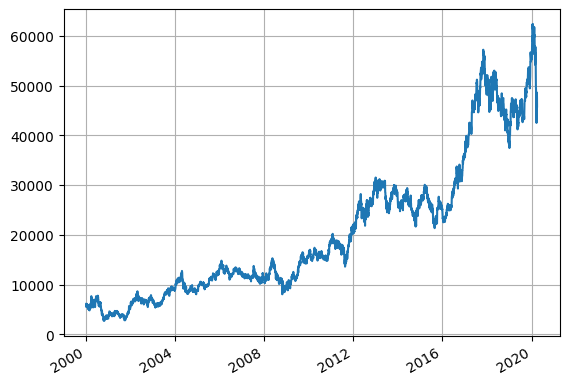

In [116]:
df.close.plot(grid=True)

### 2) preprocessing

In [127]:
X = df.drop(columns = ['volume', 'ticker', 'close'])
y = df.iloc[:, 3:4]

X.head()

,open,high,low,adjclose
2000-01-04,6000.0,6110.0,5660.0,4469.932129
2000-01-05,5800.0,6060.0,5520.0,4082.195801
2000-01-06,5750.0,5780.0,5580.0,4111.459961
2000-01-07,5560.0,5670.0,5360.0,4052.933594
2000-01-10,5600.0,5770.0,5580.0,4221.195801


In [128]:
y.head()

,close
2000-01-04,6110.0
2000-01-05,5580.0
2000-01-06,5620.0
2000-01-07,5540.0
2000-01-10,5770.0


#### 정규화

In [129]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [130]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)


# train data
X_train = X_ss[:4300, :]
X_test = X_ss[4300:, : ]

y_train = y_mm[:4300, : ]
y_test = y_mm[4300:, :]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)


train (4300, 4) (4300, 1)
test (795, 4) (795, 1)


#### to tensor

In [131]:
X_train = Variable(torch.Tensor(X_train))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_test = Variable(torch.Tensor(y_test))

X_train_tensors = torch.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_tensors = torch.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print("Training Shape", X_train_tensors.shape, y_train.shape)
print("Testing Shape", X_test_tensors.shape, y_test.shape) 


Training Shape torch.Size([4300, 1, 4]) torch.Size([4300, 1])
Testing Shape torch.Size([795, 1, 4]) torch.Size([795, 1])


### gpu

In [132]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(torch.cuda.get_device_name(0))


NVIDIA GeForce RTX 2080 Ti


## 2. model

In [133]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True
                            )

        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)


        self.relu = nn.ReLU()


    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)   # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)   # internal state

        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm sith input, hidden and internal state

        hn = hn.view(-1, self.hidden_size)  # reshaping data for dense layer next
        out = self.relu(hn)
        out = self.fc_1(out)  # first Dense
        out  = self.relu(out)
        out = self.fc(out)  # final output


        return out


## hyperpamams

In [134]:
num_epochs = 30000
leraning_rate = 0.00001

input_size = 4
hidden_size =2
num_layers = 1

num_classes = 1

In [135]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[0]).to(device)

In [136]:
lstm

LSTM(
  (lstm): LSTM(4, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [137]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(),lr = leraning_rate)

## 학습

In [138]:
losses = []
for epoch in range(num_epochs):
    outout = lstm.forward(X_train_tensors.to(device))
    optimizer.zero_grad()

    loss = loss_function(outout, y_train.to(device))

    loss.backward()

    optimizer.step()

    if epoch % 200 == 0:
        losses.append(loss.item())
        print('Epoch: %d, loss: %1.5f'%(epoch, loss.item()))

Epoch: 0, loss: 0.04204
Epoch: 200, loss: 0.03158
Epoch: 400, loss: 0.02590
Epoch: 600, loss: 0.02311
Epoch: 800, loss: 0.02182
Epoch: 1000, loss: 0.02119
Epoch: 1200, loss: 0.02080
Epoch: 1400, loss: 0.02049
Epoch: 1600, loss: 0.02021
Epoch: 1800, loss: 0.01994
Epoch: 2000, loss: 0.01965
Epoch: 2200, loss: 0.01931
Epoch: 2400, loss: 0.01891
Epoch: 2600, loss: 0.01848
Epoch: 2800, loss: 0.01801
Epoch: 3000, loss: 0.01750
Epoch: 3200, loss: 0.01695
Epoch: 3400, loss: 0.01635
Epoch: 3600, loss: 0.01570
Epoch: 3800, loss: 0.01501
Epoch: 4000, loss: 0.01429
Epoch: 4200, loss: 0.01353
Epoch: 4400, loss: 0.01275
Epoch: 4600, loss: 0.01195
Epoch: 4800, loss: 0.01113
Epoch: 5000, loss: 0.01030
Epoch: 5200, loss: 0.00948
Epoch: 5400, loss: 0.00866
Epoch: 5600, loss: 0.00785
Epoch: 5800, loss: 0.00706
Epoch: 6000, loss: 0.00630
Epoch: 6200, loss: 0.00557
Epoch: 6400, loss: 0.00488
Epoch: 6600, loss: 0.00424
Epoch: 6800, loss: 0.00364
Epoch: 7000, loss: 0.00309
Epoch: 7200, loss: 0.00259
Epoch: 7

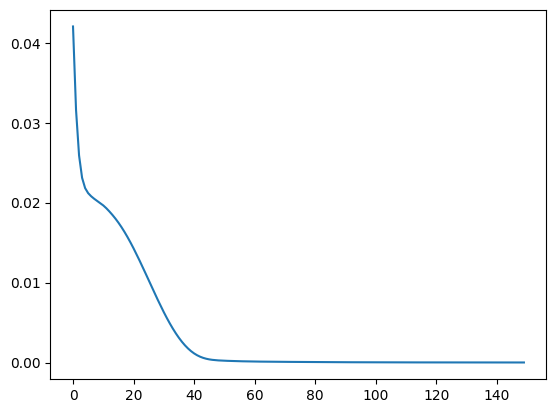

In [142]:
plt.plot(losses)

## 예측하기

In [143]:
df_X_ss = ss.transform(df.drop(columns = ['volume', 'ticker', 'close']))
df_y_mm = mm.transform(df.iloc[:, 3:4])


# converting to Tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))


print('testset shape:', df_X_ss.shape, df_y_mm.shape)

testset shape: torch.Size([5095, 1, 4]) torch.Size([5095, 1])


In [144]:
import matplotlib.pyplot as plt

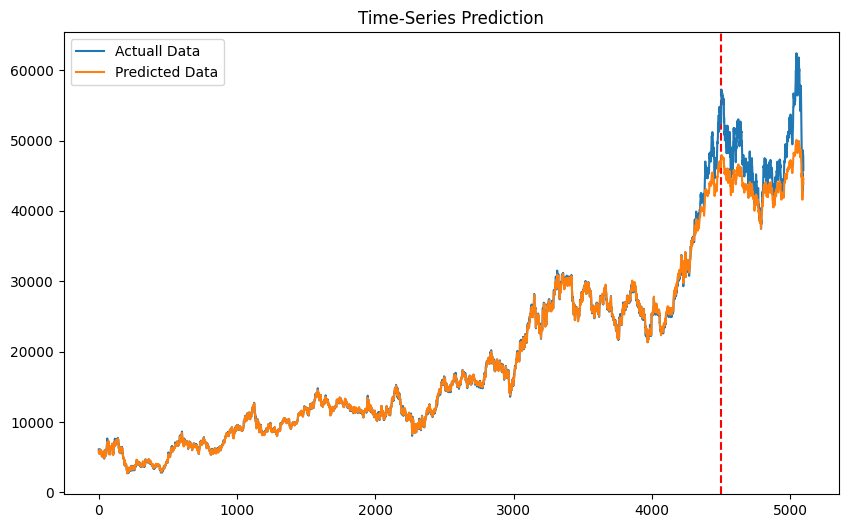

In [145]:
train_predict = lstm(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 
